In [1]:
## NLP pour l’analyse de critiques de films

In [29]:
import pandas as pd
import requests
import lxml.html as lh
page = requests.get('http://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/')
doc = lh.fromstring(page.content)

In [30]:

# URL
url_inception = 'http://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/'
url_sonic="https://www.allocine.fr/film/fichefilm-281203/critiques/spectateurs/"
# URI-SUFFIX
uri_pages = '?page='
# Number of pages to read
nbPages = 100
# XPath content to collect
tags = ['//span[@class="stareval-note"]', \
        '//div[@class="content-txt review-card-content"]' ]
cols = ['Note', \
        'Description' ]

#page = requests.get(url)
#doc = lh.fromstring(page.content)

def getPage(url):
    page = requests.get(url)
    doc = lh.fromstring(page.content)

    # Get the Web data via XPath
    content = []
    for i in range(len(tags)):
        content.append(doc.xpath(tags[i]))

    # Gather the data into a Pandas DataFrame array
    df_liste = []
    for j in range(len(tags)):
        tmp = pd.DataFrame([content[j][i].text_content().strip() for i in range(len(content[i]))], columns=[cols[j]])
        tmp['key'] = tmp.index
        df_liste.append(tmp)

    # Build the unique Dataframe with one tag (xpath) content per column
    liste = df_liste[0]
    for j in range(len(tags)-1):
        liste = liste.join(df_liste[j+1], on='key', how='left', lsuffix='_l', rsuffix='_r')
        liste['key'] = liste.index
        del liste['key_l']
        del liste['key_r']
    
    return liste

def getPages(_nbPages,_url):
    liste_finale = pd.DataFrame()
    for i in range (_nbPages):
        liste = getPage(_url + uri_pages + str(i+1))
        liste_finale = pd.concat([liste_finale, liste], ignore_index=True)
    return liste_finale

In [31]:
df_inception = getPages(nbPages,url_inception)
df_inception.head()

,Note,Description,key
0,"5,0",Après le chef d'oeuvre super-héroïque The Dark...,0
1,"5,0",C’est fou ce qu’on aime détester Christopher N...,1
2,"5,0",CHEF D’ŒUVRE ! Le film est absolument parfait ...,2
3,"5,0","Un film aussi novateur que complexe, dont la m...",3
4,"3,5",Le meilleur blockbuster de 2010 a pour thème l...,4


In [32]:

df_sonic = getPages(nbPages, url_sonic)
df_sonic.head()

,Note,Description,key
0,"5,0",Cette suite de sonic est incroyable !Le fan qu...,0
1,"4,0",une bonne suite pour les aventures de sonic au...,1
2,"3,0",Malgré deux nouveaux personnages de l'univers ...,2
3,"4,0",Très bon film ont retrouve ce qui fait l’espri...,3
4,"4,0","Super film de ouf, le fait que Knuckles soit d...",4


In [33]:
import pandas as pd 
df_final=pd.concat([df_sonic,df_inception],ignore_index=True)
print(df_final)

     Note                                        Description  key
0     5,0  Cette suite de sonic est incroyable !Le fan qu...    0
1     4,0  une bonne suite pour les aventures de sonic au...    1
2     3,0  Malgré deux nouveaux personnages de l'univers ...    2
3     4,0  Très bon film ont retrouve ce qui fait l’espri...    3
4     4,0  Super film de ouf, le fait que Knuckles soit d...    4
...   ...                                                ...  ...
2449  4,0  Un film dans le monde des rêves avec un soupço...   10
2450  0,5  scénario sans consistance et acteur principal ...   11
2451  5,0  tout bonnement fabuleux ! ce film est une pure...   12
2452  4,5  Ce film est d'une réflexion et d'une Originali...   13
2453  2,5  Agréablement surpris! Des effets spéciaux impr...   14

[2454 rows x 3 columns]


In [34]:
liste=df_inception['Description'].values.tolist()
print(liste)

['Après le chef d\'oeuvre super-héroïque The Dark Knight, Christopher Nolan a carte blanche pour réaliser son prochain long-métrage. Il se met alors à la réalisation d\'un film, co-écrit avec son frère, et qui a pour nom "Inception".Le récit mélange la réalité et le rêve. Le spectateur se méprend alors, puis apprend à discerner le vrai du faux, à trouver les clés du scénario.Inception est un chef d\'oeuvre. Un véritable chef d\'oeuvre. Christopher Nolan illustre son talent, de par sa réalisation et son scénario. Intelligence pure, ce dernier se révèle complexe à première vue. Puis, au long du visionnage, l\'on se rend peu à peu compte de sa force, de sa puissance émotionnelle, de sa capacité à brouiller les pistes. Celles-ci sont également éparpillées grâce à une mise en scène incroyable, osant le grandiose et l\'intime. Inception peut s\'avérer être un blockbuster ultra-visuel mais également un drame prenant, puisque l\'intrigue principale est finalement le deuil.Pour parfaire cette g

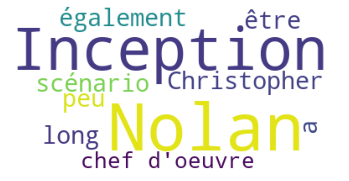

In [35]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

SW = stopwords.words('french')
# SW.append('')


WC=WordCloud(background_color = 'white',stopwords = SW,max_words = 10).generate(liste[0])


plt.imshow(WC)
plt.axis("off")
plt.show()

In [36]:
df_total=pd.concat([df_sonic,df_inception])

In [37]:
df_total.to_csv('films.csv', index=False)

# Etape 2 : Préparation des données 

In [38]:
import re
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords


In [39]:
import re 

REMPLACE_SANS_ESPACE = re.compile("[;:!\'?,\"()\[\],']")
REMPLACE_AVEC_ESPACE = re.compile("()|(-)|(/)|[.’]")
PUR_NOMBRE = re.compile("[0-9]")

def setClassBin(i):
    if (float(i.replace(',', '.')) > 3):
        return 1
    else:
        return 0

def preprocess(txt):
    txt = [PUR_NOMBRE.sub("", (str(line)).lower()) for line in txt] # retire les nombres (comme les années)
    txt = [line.replace('\n', ' ')  for line in txt] # Retire les \n (retours chariots)
    txt = [REMPLACE_SANS_ESPACE.sub(" ", line.lower()) for line in txt]
    txt = [REMPLACE_AVEC_ESPACE.sub("", line) for line in txt]

    return txt

## Retrait des accents

In [91]:
df_total["Description"] = df_total["Description"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_total.head()

,Note,Description,key
0,"5,0",cette suite sonic incroyable fan ravi quand jo...,0
1,"4,0",bonne suite aventures sonic cinema deja premie...,1
2,"3,0",malgre deux nouveaux personnages univers jeu v...,2
3,"4,0",tres bon film retrouve fait lesprit sonic film...,3
4,"4,0",super film ouf fait knuckles cote eggman debut...,4


In [40]:

df_total["Description"]=preprocess(df_total["Description"])


In [41]:
df_total["Description"]

0       cette suite de sonic est incroyable  le fan qu...
1       une bonne suite pour les aventures de sonic au...
2       malgré deux nouveaux personnages de l univers ...
3       très bon film ont retrouve ce qui fait lesprit...
4       super film de ouf  le fait que knuckles soit d...
                              ...                        
1495    un film dans le monde des rêves avec un soupço...
1496    scénario sans consistance et acteur principal ...
1497    tout bonnement fabuleux   ce film est une pure...
1498    ce film est d une réflexion et d une originali...
1499    agréablement surpris  des effets spéciaux impr...
Name: Description, Length: 2454, dtype: object

## Stopwords 

In [42]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
#df_total['Description'] = pd.DataFrame(preprocess(df_total['Description']))
french_stopwords = set(stopwords.words('french'))
filtre_stopfr =  lambda text: [token for token in text if token.lower() not in french_stopwords]
df_total['Description'] = [' '.join(filtre_stopfr(word_tokenize(item))) for item in df_total['Description']]

In [44]:

for element in df_total['Description'] :
    print(element, "\n")

cette suite sonic incroyable fan ravi quand jouais megadrive montré film devenu dingue univers jeu parfaitement respecté amour passion spoiler tails avion knuckle robotnik robot guêpes sonic fond eau absorbe bulles oxygene émeraudes clins œil droite gauche rendent hommage jeu bon sang transformation super sonic juste magnifique histoire toujours aussi sympathique sonic petite famille adoptive jim carrey incroyable eggmance film merveille vivement suite 

bonne suite aventures sonic cinéma deja premier film super bienun bon divertissement toute famille jim carrey pleine formeune suite explosive trop cool 

malgré deux nouveaux personnages univers jeu vidéo sonic knuckles tails assez loin catchline affiche fois plus fun tend plutôt vers fois moins étonnement si réfère premier opus sorti double mérite nouveauté effet surprisec malheureusement risque suites faut savoir conforter fans zone connue appréciée réussir également relancer intérêt osant quelques nouvelles recettesce sonic version 

adoré film beaucoup mieux premier loin trop aimer combats entre sonic knuckles beaucoup plus références rapport sonic sah ça fait plaisirtails toujours mignonj aimé aussi moment snowboard où knuckles raconte passé team sonic réunissent lets godeath egg robot super réaliste donc tant mieuxsuper sonic a mis tout monde accordet scène post credit apparition shadowdonc donnerais note étoiles regarderai sonic film 

film trop bien qualité film superbe dirait dedans 🤩 

excellent film voir petit comme grand jai trouvé film très bien fait scènes épiques lhumour spoiler pensais lamitié entre tails sonic allait manquer jai agréablement surpris retrouvant cette amitié si exceptionnelle jeux série revanche jai petit peu déçu car dr eggman robotnik nétait très fort super sonic battu trop vite goût ça mieux si combat entre plus long finir quand bonne touche spoiler shadow amène hype max petit défauts scénaristique sonic nétant quun ado robotnik peut avoir construit shadow détruire cela veut dire rob

trés bon film trés bonne histoire repompé malheuresement grande partie animé japonais paprika acteurs sonts excelent dicaprio génial ellen page prouve fait partie grandes maintenant ken watanabe joseph gordonlevitt cillian murphy toujours aussi bon tom hardy tout simplement énorme seule présence gache film actrice plus pitoyable jamais vue cotillard devrais etre là sait strictement jouer a aucun charisme dernier point négatif fin dit font tout ca ca fois fini rien séparent dicaprio rentre chez non franchement ca a convaincu enfin finir film génial a dire film année comme vu bah faut exagérer 

tout simplement grandiose époustouflant si explications parfois complexes ça reste pur régal courrez voir si encore fait 

vraiment étonné bon film christopher nolan 

trop bruits pr fausse complexité dommage concept intéréssant sujet chiant cotillard pleurnicharde sans talentsbref mal vraiment trop bruits pr rien merci marketing 

christopher nolan mauvais cinéaste difficile comprendre pourquoi 

« inception » plongée lunivers rêves question différentes réalités « matrix » abordée peut dire « inception » sous « matrix » car qualification « sous » péjorative fonctionne tout film cest juste « inception » peut être plus abordable dun point vue « philosophique » quun « matrix » quexpose film dailleurs très intéressant cette idée superposition « niveau » excellente romance parallèle cœur lhistoire nest ni superflue ni ennuyeuse donne sens h film passent comme lettre poste sent aucune lassitude temps parait court cela mise scène parfaitement calibré bien niveau « neige » peut être peu trop long alliant habillement moments dactions réflexions spectateur nest jamais perdu entre niveauxles décors superbes notamment premier labyrinthe créé arianeleonardo dicaprio confirme fois plus talent dacteur noter toute fois vf nest très satisfaisante « inception » film voir plusieurs fois afin bien comprendre notamment relation entre dom melune grande réussite effets spéciaux très bons bonne histoi

## Préparation des libellés

In [45]:
def setClassBin(i):
    if (float(i.replace(',', '.')) > 3):
        return 1
    else:
        return 0
yList = [setClassBin(x) for x in df_total['Note']]
df_total.drop(['Note'], axis=1)



,Description,key
0,cette suite sonic incroyable fan ravi quand jo...,0
1,bonne suite aventures sonic cinéma deja premie...,1
2,malgré deux nouveaux personnages univers jeu v...,2
3,très bon film retrouve fait lesprit sonic film...,3
4,super film ouf fait knuckles côté eggman début...,4
...,...,...
1495,film monde rêves soupçon film action apocalypt...,10
1496,scénario sans consistance acteur principal peu...,11
1497,tout bonnement fabuleux film pure merveille al...,12
1498,film réflexion originalité inégalable si film ...,13


In [46]:
df_total

,Note,Description,key
0,"5,0",cette suite sonic incroyable fan ravi quand jo...,0
1,"4,0",bonne suite aventures sonic cinéma deja premie...,1
2,"3,0",malgré deux nouveaux personnages univers jeu v...,2
3,"4,0",très bon film retrouve fait lesprit sonic film...,3
4,"4,0",super film ouf fait knuckles côté eggman début...,4
...,...,...,...
1495,"4,0",film monde rêves soupçon film action apocalypt...,10
1496,"0,5",scénario sans consistance acteur principal peu...,11
1497,"5,0",tout bonnement fabuleux film pure merveille al...,12
1498,"4,5",film réflexion originalité inégalable si film ...,13


In [47]:
yList

[1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


## Séparation des données 

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_total["Description"], yList, train_size=0.8, random_state=0)

In [51]:
print(X_train)

508    décidemment nolan génie absolu refusant tourne...
664    bien complexe très bon film a voir absolument ...
326    malgré très bonne idée départ scénario mauvais...
374    peu moins mitraillettes peu moins issues tortu...
380    blockbuster inception a conçu comme tel specta...
                             ...                        
79     grand film chef oeuvre acteurs merveilleux peu...
777    vu ensemble critiques pense tout simplement fi...
763    vraiment mal respectent bien personnages détai...
835    vraiment mal respectent bien personnages détai...
699    arrrrrrrrg allé voir très enthousiaste franche...
Name: Description, Length: 1963, dtype: object


## Data augmentation

## Bag  of Words

In [71]:

from sklearn.feature_extraction.text import CountVectorizer


In [72]:
cv = CountVectorizer(lowercase=False, min_df=0.1)
cv = cv.fit(X_train)
cv_matrix=cv.transform(X_train)

print(cv_matrix.shape, "\n", type(cv_matrix))

(1963, 78) 
 <class 'scipy.sparse.csr.csr_matrix'>


In [67]:
df_bow = pd.DataFrame(cv_matrix.toarray(), index = X_train.index, columns = cv.get_feature_names())
df_bow.head()

,acteurs,action,alors,ans,après,assez,aussi,autres,avoir,beaucoup,...,toujours,tous,tout,trop,très,voir,vraiment,vu,ça,être
508,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
326,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,2,0,0,0,0,0
374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
380,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0


## Entrainement du modèle 


In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
model_LR = LogisticRegression(solver="liblinear", random_state=0)

#Entrainement du modèle
model_LR.fit(df_bow, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [80]:
cv_X_test = cv.transform(X_test)
cv_X_test.shape
X_test_bow = pd.DataFrame(cv_X_test.toarray(), index = X_test.index, columns = cv.get_feature_names())
X_test_bow
#Prédiction du y
y_pred = model_LR.predict(X_test_bow)

In [89]:
score = model_LR.score(X_test_bow, y_test)
print(score)

0.8513238289205702
